# Exploratory Data Analysis

This notebook is for exploratory data analysis of the TMBD Box Office Prediction dataset.

In [108]:
import os
import sys
import subprocess
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import sklearn
import seaborn as sns

# This boilerplate gives notebook access to the project's Python modules.
# **WARNING:** This snippet may need to be modified if the notebook is moved.
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Load the data
To do this step, you need a Kaggle API token.

Download the Kaggle API token from your "My Account" page of Kaggle.com.

Place the downloaded token `kaggle.json`  in the directory `~/.kaggle`. This is where the `kaggle` execuable looks for the API token.

### TODO
- once this is working, put it in the module `tmbd.make_dataset`
- write a `Makefile` with targets implemented by these functions to manage dependencies between steps
  - e.g., prevent redownloading the dataset if not necessary

In [6]:
from tmbd.make_dataset import RAW_DATA_DIR, FIG_DIR

def download_data():
    """Download and extract the Kaggle data."""
    RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
    subprocess.run(["kaggle", "competitions", "download",
                    "tmdb-box-office-prediction", "-p", 
                    str(RAW_DATA_DIR)],
                  check=True)
    
    for zp in RAW_DATA_DIR.glob("*.zip"):
        ZipFile(zp).extractall(path=RAW_DATA_DIR)

def load_test():
    """Read the test.csv file into a Pandas dataframe."""
    return pd.read_csv(RAW_DATA_DIR.joinpath("test.csv"))

def load_train():
    """Read the train.csv file into a Pandas dataframe."""
    return pd.read_csv(RAW_DATA_DIR.joinpath("train.csv"), index_col=0)

FIG_DIR.mkdir(exist_ok=True)

In [10]:
train = load_train()
display(train.dtypes)
display(train.describe())

belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


## Scatter Matrix
- resulting histograms are not very informative
    - e.g. log scale needed to get better perspective
- scatter plots show some heteroscedasticity
    - will log scale mitigate? something to try
- Helpful documentation:
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html

**TODO**:
- redo in log scale
- manually set axes of figure with axes returned by `scatter_matrix`

<Figure size 720x720 with 0 Axes>

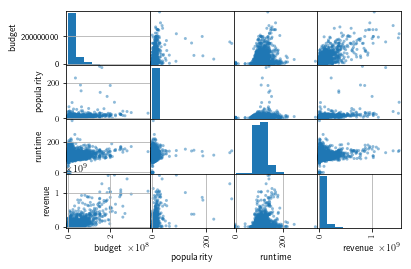

In [38]:
fig = plt.figure(figsize=(10,10))
scatter_matrix = pd.plotting.scatter_matrix(train)
fig.savefig(FIG_DIR.joinpath("scatter_matrix.png"))

## Budget
At this point no cleaning has been applied. By plotting a histogram of $\log(1 + \mathtt{budget})$ we see that budget is a missing datapoint for about 800 movies.

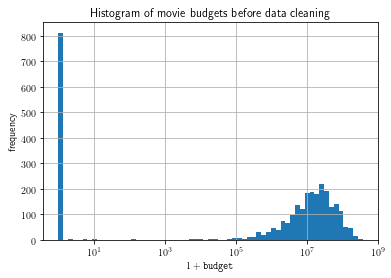

In [40]:
x = train["budget"] + 1 # add 1 to prevent undefined values in log scale
bins = np.geomspace(np.amin(x),np.amax(x),num=64)

fig, ax = plt.subplots()
ax.set_xlabel(r"$1 + \mathtt{budget}$")
ax.set_ylabel(r"frequency")
ax.hist(x,bins=bins)
ax.set_xscale("log")
ax.set_title("Histogram of movie budgets before data cleaning")
fig.savefig(FIG_DIR.joinpath("budget_histogram.png"))

## Genres

In [69]:

genres = train["genres"].fillna("[]").apply(ast.literal_eval)

In [110]:
import ast
def process_genres(genres_string):
    """Process an entry in the 'genres' column to get a list of genres as strings.
    WARNING: This function cannot handle NaN or NA value; ensure that NaNs are 
    replaced with the empty string before running""" 
    return [genre["name"] for genre in ast.literal_eval(genres_string)]

genres = train["genres"].fillna("[]").apply(process_genres)
mlb = sklearn.preprocessing.MultiLabelBinarizer()

genre_matrix = mlb.fit_transform(genres)
genre_df = pd.DataFrame(genre_matrix,columns = mlb.classes_)
display(genre_df.head())

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Genre Correlation Matrix

It's illustrative to plot the correlation between pairs of genres. The results make intuitive sense:
- Positive correlation between:
    - Action, Adventure, and Thriller
    - Animation and Family
    - History and War
- Negative correlation between:
    - Comedy and Thriller
    
Questions for further inquiry:
- What would this look like if box office revenue or budget was taken into account?
    - What genre combinations are winners at the box office?

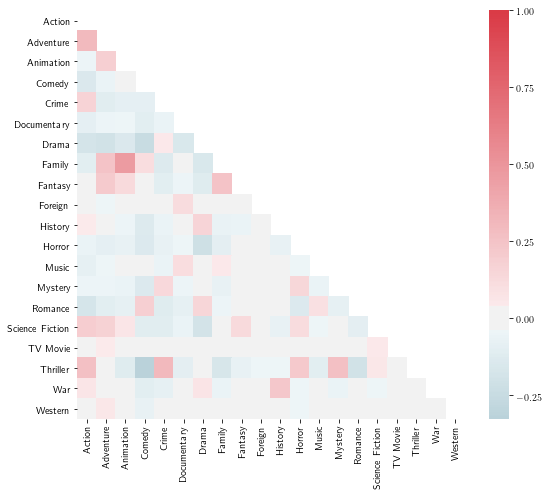

In [113]:
corr = genre_df.corr()

mask = np.zeros_like(corr.values)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (8,7))
sns.heatmap(corr, ax = ax, mask = mask, center = 0,
            cmap = sns.diverging_palette(220, 10, as_cmap=True))

plt.tight_layout()
fig.savefig(FIG_DIR.joinpath("genre_correlation.png"))